In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 

# ctapipe modules
from ctapipe import utils
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.io import EventSeeker 

from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader

run=1232 # 22/05
# change this path with your own
file = '/ctadata/NectarCAM/2019/20190522/NectarCAM.Run{}.0000.fits.fz'.format(run)

reader = event_source(file, max_events=None)
print(f"Read files {reader.file_list}")
channel=['HG','LG']

tel_id=0 # hopefully it will be 1 for EvB v3

ImportError: cannot import name 'event_source' from 'ctapipe.io' (/home/amikhno/local/opt/conda/envs/nectar-dev/lib/python3.11/site-packages/ctapipe/io/__init__.py)

In [4]:
# read first pedestal event

for i,event in enumerate(reader): 
    
    if event.r1.tel[0].trigger_type==32:
        break
    
  
        
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")


read event id: 218, trigger 32


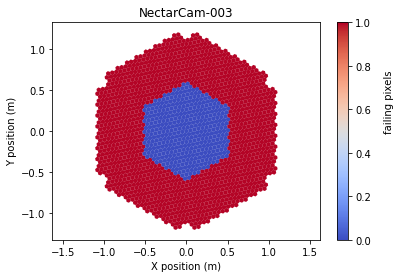

In [5]:
# the prototype has only the central pixels
disp = CameraDisplay(event.inst.subarray.tels[0].camera)

chan = 0                                                                                 
disp.image = event.mon.tel[tel_id].pixel_status.hardware_failing_pixels[chan]
disp.set_limits_minmax(0,1)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'failing pixels', rotation=90)
disp.add_colorbar()


In [19]:
event.nectarcam.tel[0].svc.module_ids


array([ 63,  64,  65,  66,  67,  78,  79,  80,  81,  82,  83,  94,  95,
        96,  97,  98,  99, 100, 111, 112, 113, 114, 115, 116, 117, 118,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 146, 147, 148, 149,
       150, 151, 152, 153, 164, 165, 166, 167, 168, 169, 170, 181, 182,
       183, 184, 185, 186, 197, 198, 199, 200, 201], dtype=uint16)

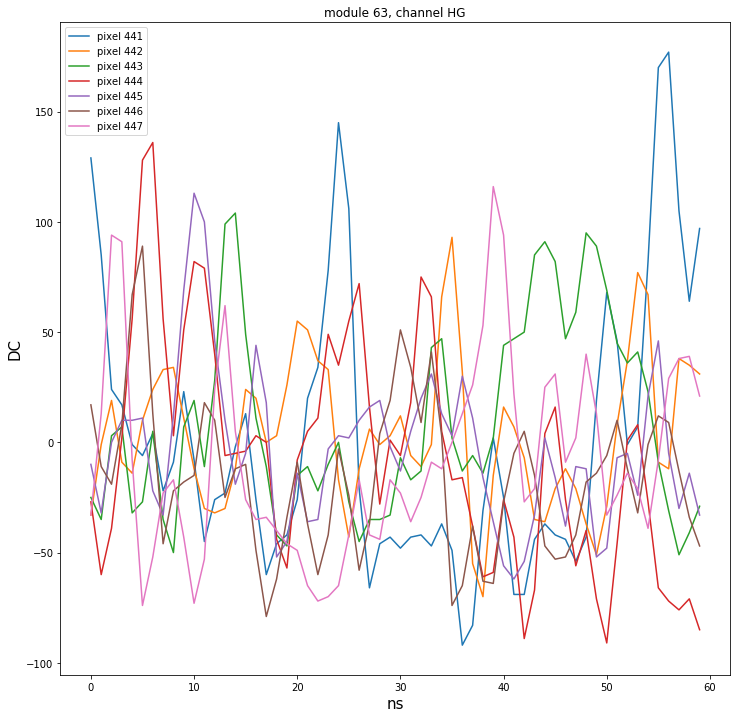

In [7]:
# plot R1 waveform of module [module]
def view_waveform(chan=0, pix_id=6):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {module}, channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

# module number    

module=63
module_rank=np.where(event.nectarcam.tel[0].svc.module_ids==module)

# ids of pixel in module
pixels_mod=event.nectarcam.tel[0].svc.pixel_ids[module_rank[0][0]*7:module_rank[0][0]*7+7]
#
# channel
chan=0
# ids of pixel in module
#pixels_mod=event.nectarcam.tel[0].svc.pixel_ids[module*7:module*7+7]
 
fig = plt.figure(num=0,figsize=(12,12))     

for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

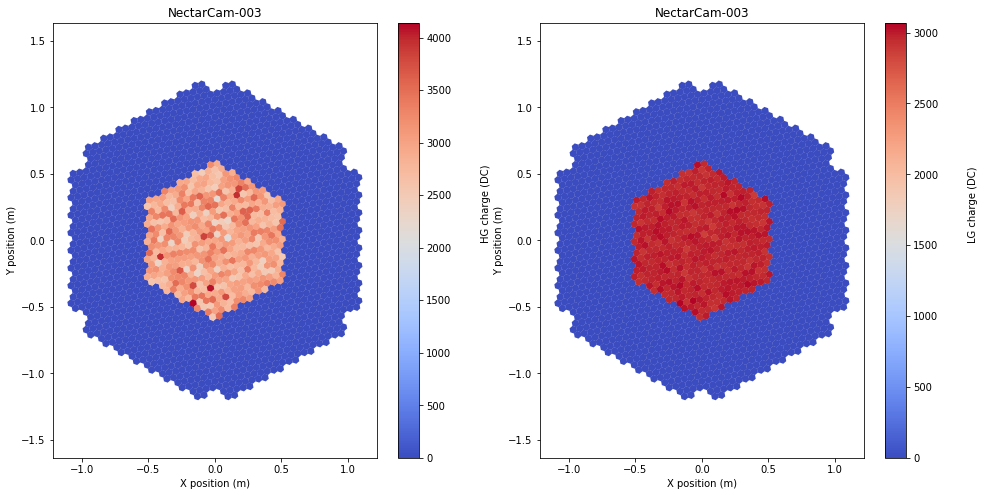

In [8]:
# integrate the charge on 12 ns around the peak value

config = Config({
    "FixedWindowSum": {
        "window_start": 12,
        "window_width": 12 
    }
})
#integrator = LocalPeakWindowSum(config=config)
integrator = FixedWindowSum(config=config)


waveform=event.r0.tel[0].waveform
image, peakpos = integrator(waveform)

fig = plt.figure(figsize=(16, 8))
for chan in(np.arange(2)):
    ax = plt.subplot(1, 2, chan+1)

    disp = CameraDisplay(event.inst.subarray.tels[0].camera)
    disp.image = image[chan]  
    #disp.set_limits_minmax(0,200)
    disp.cmap = plt.cm.coolwarm
    disp.axes.text(2.0, 0, f'{channel[chan]} charge (DC)', rotation=90)
    disp.add_colorbar()
    
    disp.update()
#plt.savefig(f"Run{run}_pedestalevent_{event.lst.tel[0].evt.event_id}.png")   

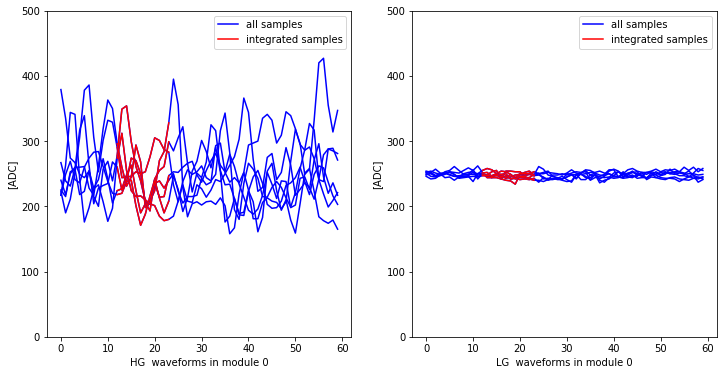

In [9]:
# Plot the part of the waveform that is integrated
# (this work only after the line above)

fig = plt.figure(0,figsize=(12,6))

# consider only 36 samples
samples=np.arange(0,60)

# chose the module
mod = 0

# find pixel index in module
pix_in_mod = event.nectarcam.tel[0].svc.pixel_ids[mod*7:mod*7+7]

for chan in(np.arange(2)): 

    plt.subplot(1,2,chan+1)
    
    for i,pix in enumerate(pix_in_mod):
    
        # samples used to calculate the charge
        start=int(max(integrator.window_start,0))
        stop=int(min(start+integrator.window_width,60))
        used_samples=np.arange(start,stop)
        used=waveform[chan,pix,start:stop]
        
        
        plt.plot(waveform[chan,pix], color='b', label='all samples')
        plt.plot(used_samples,used, color='r', label='integrated samples')
       
        if i==0:
            plt.legend()
        plt.ylabel("[ADC]")
        plt.xlabel(f"{channel[chan]}  waveforms in module {mod}")
        plt.ylim(0,500)
        #fig.savefig(f"Run{run}_waveform_pedestal_module_{mod}.png")




get container after at event 5602 after 2692 events


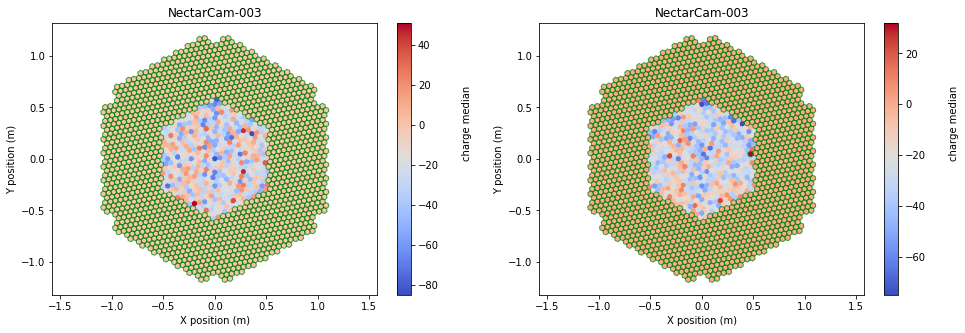

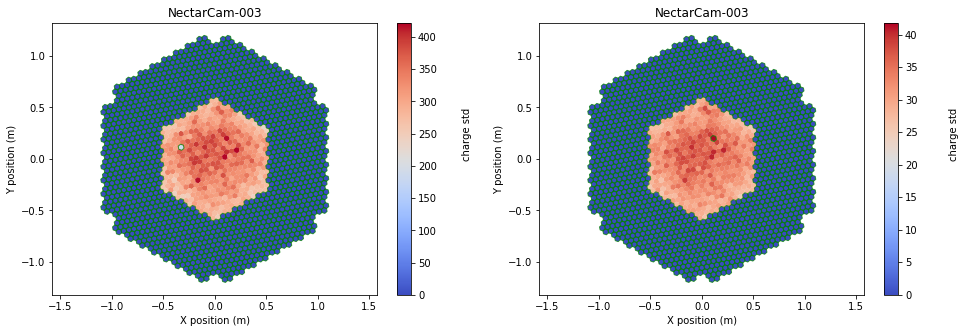

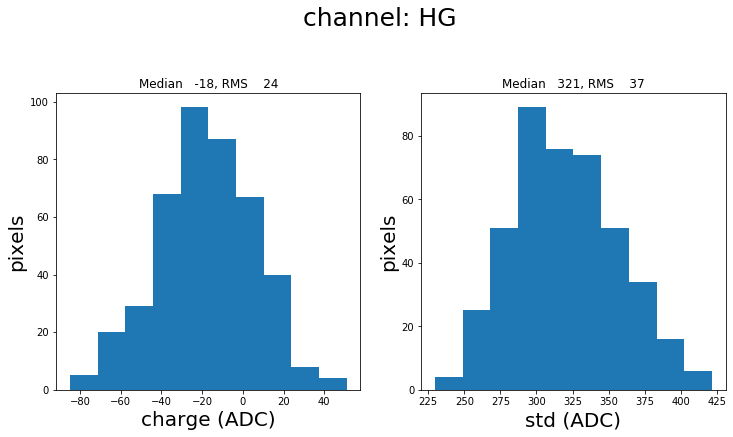

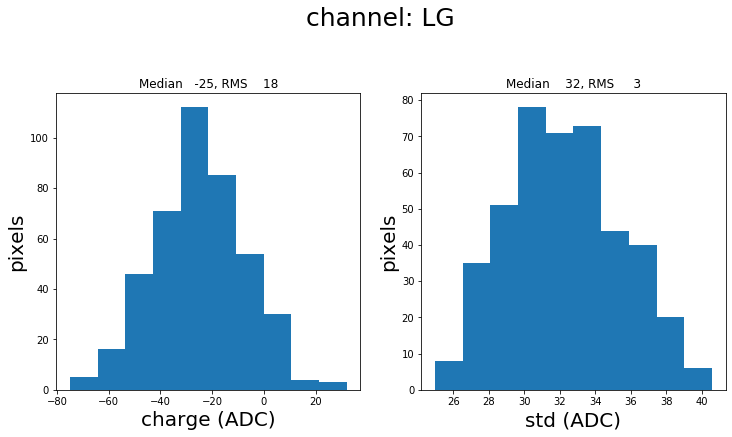

In [10]:
# fill pedestal container and write it on disk

from ctapipe.calib.camera.pedestals import PedestalIntegrator

# declare a writer
filename= f"pedestal_run{run}.hdf5"
tel_id = 0

# configuration for the charge integrator
charge_config = Config({
    "FixedWindowSum": {
        "window_start": 12,
        "window_width": 12,
    }
    
})
    
# declare the pedestal component
pedestal = PedestalIntegrator(tel_id=tel_id,
                                    sample_size = 1000,
                                    sample_duration = 10000,  
                                    charge_median_cut_outliers = [-3,3],
                                    charge_std_cut_outliers = [-3,3],
                                    charge_product="FixedWindowSum",
                                    config=charge_config)




for i, event in enumerate(reader):


    # select only pedestal events    
    if event.r1.tel[tel_id].trigger_type != 32:        
        continue
    
    if pedestal.calculate_pedestals(event):
        ped_data = event.mon.tel[tel_id].pedestal
        status_data = event.mon.tel[tel_id].pixel_status
       
        print(f"get container after at event {event.r0.event_id} after {i+1} events")
        # stop after first event
        break
        

fig = plt.figure(11,figsize=(16, 5))
mask=  np.logical_or(ped_data.charge_median_outliers,status_data.hardware_failing_pixels) 

image = ped_data.charge_median
#plt.savefig(f"std_{channel[chan]}.png")
chan =0
        
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge median', rotation=90)
ax = plt.subplot(1, 2, 2)
chan =1
        
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge median', rotation=90)
disp.add_colorbar()   
#plt.savefig(f"Run{run}_pedestal_median_r1_over_camera.png")        
# plot data
fig = plt.figure(10,figsize=(16, 5))
        

image = ped_data.charge_std
mask=  np.logical_or(ped_data.charge_std_outliers,status_data.hardware_failing_pixels) 
chan =0      
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge std', rotation=90)
disp.add_colorbar()

ax = plt.subplot(1, 2, 2)
chan=1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge std', rotation=90)
#plt.savefig(f"Run{run}_pedestal_std_r1_over_camera.png") 
#
#plt.savefig(f"pedestal_median_r1.png")        
for chan in np.arange(2):
            
    fig = plt.figure(chan,figsize=(12,12))
    median_charge=ped_data.charge_median[chan]
    std_charge=ped_data.charge_std[chan]
    mean_charge=ped_data.charge_mean[chan]
    median_charge=ped_data.charge_median[chan]
            
    select = np.logical_not(mask[chan])

    fig.suptitle(f"channel: {channel[chan]}", fontsize=25) 
    plt.subplot(221)
    median= np.median(median_charge[select]) 
    rms= np.std(median_charge[select])
    plt.title(f"Median {median:5.0f}, RMS {rms:5.0f}") 
    plt.xlabel('charge (ADC)',fontsize=20)
    plt.ylabel('pixels',fontsize=20)  
           
    plt.hist(median_charge[select])  
    plt.subplot(222)
    plt.ylabel('pixels',fontsize=20) 
    plt.xlabel('std (ADC)',fontsize=20)
    
    plt.hist(std_charge[select])
    median= np.median(std_charge[select]) 
    rms= np.std(std_charge[select])
    plt.title(f"Median {median:5.0f}, RMS {rms:5.0f}") 
   
 
    #plt.savefig(f"Run{run}_pedestal_{channel[chan]}.png")
    
      

In [12]:
# use the tool to write flat fields (still with partial waveform treatement)
from nectarchain.tools.write_pedestals import PedestalHDF5Writer
pedestal_tool= PedestalHDF5Writer()
#pedestal_tool.print_help()

In [14]:
# change the path with that of your *.json file
pedestal_tool.run(argv=['--config','../nectarchain/tools/write_pedestals_param.json'])

INFO [PedestalHDF5Writer] (tool/initialize): ctapipe version 0.6.2.post183+gitc5fe5fe
INFO [PedestalHDF5Writer] (tool/run): Starting: PedestalHDF5Writer
INFO [PedestalHDF5Writer.PedestalIntegrator] (pedestals/__init__): extractor <ctapipe.image.extractor.FixedWindowSum object at 0x7ff7391e2240>
INFO [PedestalHDF5Writer.PedestalIntegrator] (pedestals/__init__): Used events statistics : 100
INFO [PedestalHDF5Writer] (tool/run): CONFIG: {'PedestalHDF5Writer': {'calculator_product': 'PedestalIntegrator', 'config_file': '../nectarchain/tools/write_pedestals_param.json', 'log_datefmt': '%Y-%m-%d %H:%M:%S', 'log_format': '%(levelname)s [%(name)s] (%(module)s/%(funcName)s): %(message)s', 'log_level': 10, 'output_file': 'pedestal.hdf5'}}
DEBUG [PedestalHDF5Writer] (write_pedestals/start): write event in table: tel_0/pedestal
INFO [PedestalHDF5Writer] (tool/run): Finished: PedestalHDF5Writer
INFO [PedestalHDF5Writer] (tool/run): Output: /scratch4/franca/soft/nectarchain/notebooks/pedestal.hdf5
D

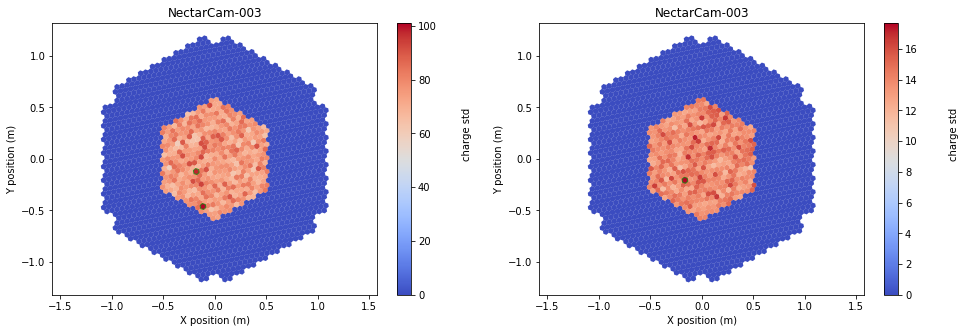

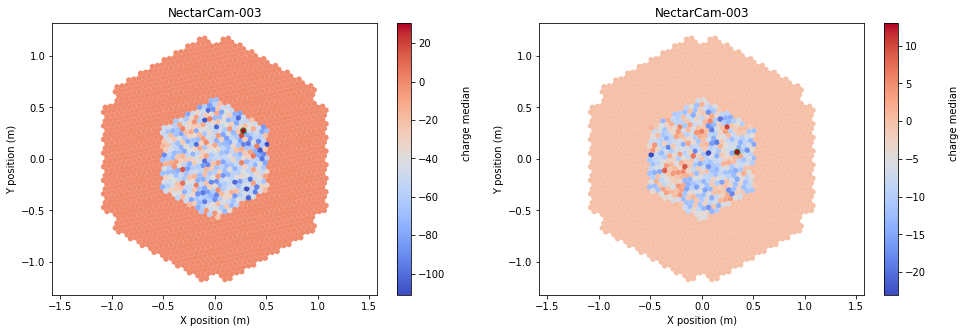

In [15]:
# read back pedestalContainer container written with the tool calc_pedestal.py
from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader
ped_data = PedestalContainer()
# change the path with that of your *.hdf5  file
with HDF5TableReader('../nectarchain/tools/pedestal.hdf5') as h5_table:
    
    assert h5_table._h5file.isopen == True

    count = 0
    ped_charge = [] 
    ped_std = []
    for ped_data in h5_table.read('/tel_0/pedestal', ped_data):
        count+=1
        ped_charge.append([np.median(ped_data.charge_median, axis=1)])
        ped_std.append([np.median(ped_data.charge_std, axis=1)])
         
        if count != 1:
            continue
            
        
        fig = plt.figure(10,figsize=(16, 5))
        
        chan =0
        image = ped_data.charge_std
        mask=  ped_data.charge_std_outliers 
       
        ax = plt.subplot(1, 2, 1)
        disp = CameraDisplay(event.inst.subarray.tels[0].camera)
        disp.highlight_pixels(mask[chan])
        disp.image = image[chan]  
        disp.cmap = plt.cm.coolwarm
        disp.axes.text(2.4, 0, 'charge std', rotation=90)
        disp.add_colorbar()

        ax = plt.subplot(1, 2, 2)
        chan=1
        disp = CameraDisplay(event.inst.subarray.tels[0].camera)
        disp.highlight_pixels(mask[chan])
        disp.image = image[chan]  
        disp.cmap = plt.cm.coolwarm
        disp.add_colorbar()
        disp.axes.text(2.4, 0, 'charge std', rotation=90)
        
        fig = plt.figure(11,figsize=(16, 5))
        mask=  ped_data.charge_median_outliers 
        image = ped_data.charge_median
        chan =0
        
        ax = plt.subplot(1, 2, 1)
        disp = CameraDisplay(event.inst.subarray.tels[0].camera)
        disp.highlight_pixels(mask[chan])
        disp.image = image[chan]  
        disp.cmap = plt.cm.coolwarm
        disp.add_colorbar()
        disp.axes.text(2.4, 0, 'charge median', rotation=90)
        ax = plt.subplot(1, 2, 2)
        chan =1
        
        disp = CameraDisplay(event.inst.subarray.tels[0].camera)
        disp.highlight_pixels(mask[chan])
        disp.image = image[chan]  
        disp.cmap = plt.cm.coolwarm
        disp.axes.text(2.4, 0, 'charge median', rotation=90)
        disp.add_colorbar()   
        
